In [120]:
import sys
import matplotlib.pyplot as plt
import numpy as np
import irtemp
import edge_detection as ed
import pixel_analysis as pa
import pandas as pd

## PART A:
### The temperature profile of the samples and plate is determined by detecting the edges, filling and labeling them, and monitoring the temperature at their centroids.

#### Use the function 'edge_detection.input_file' to load the input file

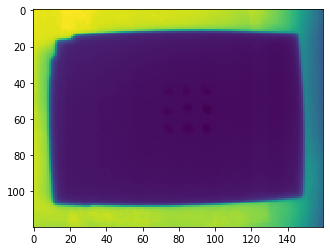

In [3]:
frames = ed.input_file('../musicalrobot/data/10_17_19_PPA_Shallow_plate.tiff')
plt.imshow(frames[0])

In [4]:
len(frames)

887

#### Crop the input file if required to remove the noise and increase the accuracy of edge detection

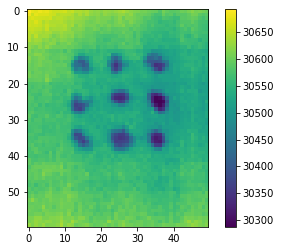

In [94]:
crop_frame = []
for frame in frames:
    crop_frame.append(frame[30:90,60:110])
plt.imshow(crop_frame[0])
plt.colorbar()

#### Use the wrapping function edge_detection.inflection_temp 

In [6]:
# Using the wrapping function
sorted_regprops, s_temp, p_temp, inf_temp, m_df = ed.inflection_temp(crop_frame, 3, 3)

/Users/cheng-yuanwu/Desktop/musical-robot-origin/examples/edge_detection.py:293: RuntimeWarning: invalid value encountered in true_divide
  derivative = gradient[:,1]/gradient[:,0]


In [7]:
sorted_regprops[0]

,Row,Column,Plate_temp(cK),Radius,Plate_coord,Area,Perim,Sample_temp(cK)
unique_index,,,,,,,,
2.0,14.0,14.0,30562.0,2.820948,19.820948,25.0,15.656854,30406.0
55.0,26.0,13.0,30528.0,2.705758,18.705758,23.0,14.828427,30366.0
7.0,35.0,14.0,30544.0,2.931615,19.931615,27.0,17.071068,30376.0
10.0,14.0,23.0,30528.0,2.705758,28.705758,23.0,15.071068,30430.0
16.0,23.0,25.0,30534.0,2.705758,30.705758,23.0,14.828427,30350.0
95.0,35.0,25.0,30497.0,3.241022,31.241022,33.0,18.242641,30359.2
47.0,14.0,35.0,30526.0,3.141275,41.141275,31.0,18.485281,30394.4
81.0,24.0,35.0,30526.0,2.985411,40.985411,28.0,17.656854,30291.0
73.0,35.0,35.0,30524.0,2.646284,40.646284,22.0,14.242641,30317.0


# sample temperature by multiple pixel calculation

In [8]:
from scipy.ndimage.morphology import binary_fill_holes
from skimage.measure import label
from skimage.measure import regionprops
from skimage.morphology import remove_small_objects
from skimage import feature
from skimage.draw import circle

In [9]:
for size in range(15, 9, -1):
    for thres in range(1500, 900, -100):
        edges = feature.canny(crop_frame[0]/thres)
        filled_samples = binary_fill_holes(edges)
        cl_samples = remove_small_objects(filled_samples, min_size=size)
        labeled_samples = label(cl_samples)
        props = regionprops(labeled_samples, intensity_image=crop_frame[0])

In [10]:
props = regionprops(labeled_samples, intensity_image=crop_frame[0])
# Initializing arrays for all sample properties obtained from regprops.
row = np.zeros(len(props)).astype(int)
column = np.zeros(len(props)).astype(int)
area = np.zeros(len(props))
radius = np.zeros(len(props))
perim = np.zeros(len(props))
intensity = np.zeros(len(props), dtype=np.float64)
plate = np.zeros(len(props), dtype=np.float64)
plate_coord = np.zeros(len(props))

c = 0
for prop in props:
    row[c] = int(prop.centroid[0])
    column[c] = int(prop.centroid[1])
            # print(y[c])
    area[c] = prop.area
    perim[c] = prop.perimeter
    radius[c] = prop.equivalent_diameter/2
    rr, cc = circle(row[c], column[c], radius = radius[c]/3)
    intensity[c] = np.mean(crop_frame[0][rr,cc])
    plate[c] = crop_frame[0][row[c]][column[c]+int(radius[c])+3]
    plate_coord[c] = column[c]+radius[c]+3
    
    c = c + 1

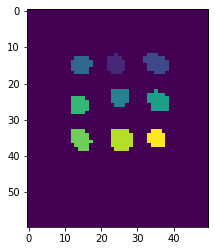

In [23]:
plt.imshow(labeled_samples)

In [36]:
labeled_samples[12]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0])

# get the range of the sample by crop_frame

In [13]:
for sample in range(len(column)):
    a=[]
    for row in range(len(labeled_samples)):
        x=labeled_samples[row]
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
        number=get_indexes(sample+1,x)
        a.append(number)
        while [] in a:
            a.remove([])
        
        new_data1=[]
        for i in range(len(a)):
            new_data1.append(min(a[i]))
        
        new_data2=[]
        for i in range(len(a)):
            new_data2.append(max(a[i]))
    b=[]
    for row in range(len(labeled_samples)):
        o=labeled_samples[row]
        get_indexes = lambda o, os: [i for (y, i) in zip(os, range(len(os))) if o == y]
        root=get_indexes(sample+1,o)
        if root != [] :
            b.append(row)
    crop_area = (np.max(b)-np.min(b)+1)*(max(new_data2)-min(new_data1)+1)
    envir_area = crop_area - area[sample]
    print("sample",sample+1,"row:from",np.min(b),"to",np.max(b),'  ',
          "column:from",min(new_data1)   ,"to",max(new_data2),'  ', "crop_area:", crop_area,
          '  ', "envir_area:",envir_area)

    

sample 1 row:from 12 to 17    column:from 22 to 26    crop_area: 30    envir_area: 7.0
sample 2 row:from 12 to 17    column:from 32 to 38    crop_area: 42    envir_area: 11.0
sample 3 row:from 13 to 17    column:from 12 to 17    crop_area: 30    envir_area: 5.0
sample 4 row:from 22 to 26    column:from 23 to 27    crop_area: 25    envir_area: 2.0
sample 5 row:from 22 to 27    column:from 33 to 38    crop_area: 36    envir_area: 8.0
sample 6 row:from 24 to 28    column:from 12 to 16    crop_area: 25    envir_area: 2.0
sample 7 row:from 33 to 38    column:from 12 to 17    crop_area: 36    envir_area: 9.0
sample 8 row:from 33 to 38    column:from 23 to 28    crop_area: 36    envir_area: 3.0
sample 9 row:from 33 to 37    column:from 33 to 37    crop_area: 25    envir_area: 3.0


In [14]:
a_1=[]
for row in range(len(labeled_samples)):
    x=labeled_samples[row].tolist()
    get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
    number=np.sum(crop_frame[0][row][get_indexes(1,x)])
    a_1.append(number)
final_sum=np.sum(a)
result = final_sum/area[0]

In [98]:
for dot in range(len(column)):
    e=[]
    for row in range(len(labeled_samples)):
        x=labeled_samples[row].tolist()
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
        number=np.sum(crop_frame[0][row][get_indexes(dot+1,x)])
        e.append(number)
    final_sum=np.sum(e)
    result = final_sum/area[dot]
    print("sample", dot+1,"temperature",result )

sample 1 temperature 30445.478260869564
sample 2 temperature 30430.129032258064
sample 3 temperature 30469.32
sample 4 temperature 30405.91304347826
sample 5 temperature 30367.071428571428
sample 6 temperature 30441.130434782608
sample 7 temperature 30449.703703703704
sample 8 temperature 30409.969696969696
sample 9 temperature 30385.545454545456


In [133]:
for sample in range(len(column)):
    a=[]
    for row in range(len(labeled_samples)):
        x=labeled_samples[row]
        get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
        number=get_indexes(sample+1,x)
        a.append(number)
        while [] in a:
            a.remove([])
        
        new_data1=[]
        for i in range(len(a)):
            new_data1.append(min(a[i]))
        
        new_data2=[]
        for i in range(len(a)):
            new_data2.append(max(a[i]))
   
    
    a_2=[]
    for dot in range(len(column)):
        e=[]
        for row in range(len(labeled_samples)):
            x=labeled_samples[row].tolist()
            get_indexes = lambda x, xs: [i for (y, i) in zip(xs, range(len(xs))) if x == y]
            number=np.sum(crop_frame[0][row][get_indexes(dot+1,x)])
            e.append(number)
        final_sum=np.sum(e)
        a_2.append(final_sum)

   
    b=[]
    for row in range(len(labeled_samples)):
        o=labeled_samples[row]
        get_indexes = lambda o, os: [i for (y, i) in zip(os, range(len(os))) if o == y]
        root=get_indexes(sample+1,o)
        if root != [] :
            b.append(row)
    crop_area = (np.max(b)-np.min(b)+1)*(max(new_data2)-min(new_data1)+1)
    envir_area = crop_area - area[sample]
    
    c=[]
    for i in range(np.max(b)-np.min(b)+1):
        for j in range(max(new_data2)-min(new_data1)+1):
            crop_temp = crop_frame[0][np.min(b)+i][min(new_data1)+j]
            c.append(crop_temp)
    crop_total = sum(c)
    envir_total_temp = crop_total - a_2[sample]
    envir_average_temp = round(envir_total_temp/envir_area)
    print("sample",sample+1,"  ", "sample_temperature",round(a_2[sample]/area[sample]) ,"row:from",np.min(b),"to",np.max(b),' ',
          "column:from",min(new_data1)   ,"to",max(new_data2),'  ', "crop_area:", crop_area,
          '  ', "envir_area:",envir_area,' ', "envir_average_temp:", envir_average_temp)

sample 1    sample_temperature 30445.0 row:from 12 to 17   column:from 22 to 26    crop_area: 30    envir_area: 7.0   envir_average_temp: 30531.0
sample 2    sample_temperature 30430.0 row:from 12 to 17   column:from 32 to 38    crop_area: 42    envir_area: 11.0   envir_average_temp: 30514.0
sample 3    sample_temperature 30469.0 row:from 13 to 17   column:from 12 to 17    crop_area: 30    envir_area: 5.0   envir_average_temp: 30539.0
sample 4    sample_temperature 30406.0 row:from 22 to 26   column:from 23 to 27    crop_area: 25    envir_area: 2.0   envir_average_temp: 30503.0
sample 5    sample_temperature 30367.0 row:from 22 to 27   column:from 33 to 38    crop_area: 36    envir_area: 8.0   envir_average_temp: 30484.0
sample 6    sample_temperature 30441.0 row:from 24 to 28   column:from 12 to 16    crop_area: 25    envir_area: 2.0   envir_average_temp: 30520.0
sample 7    sample_temperature 30450.0 row:from 33 to 38   column:from 12 to 17    crop_area: 36    envir_area: 9.0   envir

In [83]:
for sample in range(len(column)):
    print(sample)

0
1
2
3
4
5
6
7
8


#### Plotting the locations at which the temperature was recorded

Text(0.5, 1.0, 'Sample centroid and plate locations at which the temperature profile is monitored')

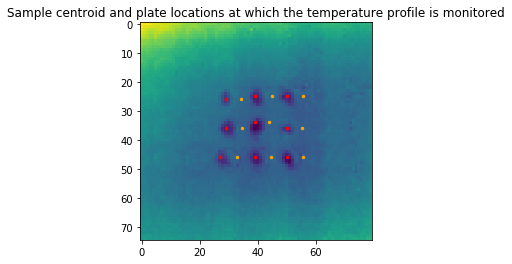

In [168]:
# Plotting the original image with the samples
# and centroid and plate location
plt.imshow(crop_frame[0])
plt.scatter(sorted_regprops[0]['Plate_coord'],sorted_regprops[0]['Row'],c='orange',s=6)
plt.scatter(sorted_regprops[0]['Column'],sorted_regprops[0]['Row'],s=6,c='red')#the origin location of the samples
plt.title('Sample centroid and plate locations at which the temperature profile is monitored')

In [ ]:
# Plotting the temperature profile of a sample against the temperature profile
# of the plate at a location next to the sample.
plt.plot(p_temp[5],s_temp[5])
plt.ylabel('Temperature of the sample($^\circ$C)')
plt.xlabel('Temperature of the well plate($^\circ$C)')
plt.title('Temperature of the sample against the temperature of the plate')

## Part B:
* The temperature profile of the samples and the plate is obtained by summing the pixel values over individual rows and columns, finding the troughs in the array of all the column and row sums.
* The temperature profile is then obtained by monitoring the temperature value at the intersection of peak values in the column and row sums. 

#### Load the input file as frames

#### Use the function irtemp.pixel_temp to get the temperature of the samples and at plate locations next to the samples in every frame of the input video.

In [ ]:
m_df = pa.pixel_temp(crop_frame,len(crop_frame),n_columns = 3, n_rows = 3)